# VK CUP

### Описание задачи -- Vk Ads Auction Forecasting Challenge

Реклама ВКонтакте работает по тем же принципам, что и большинство рекламных систем – на основе аукциона (тут можно ссылку на мой доклад из VK Tech). Чем больше рекламодатель готов заплатить за показ рекламы пользователю – тем больше людей увидят его рекламу.   

Ваша задача – предсказать, какое количество людей увидят конкретное рекламное объявление в будущем.

Вам даны:
- датасет пользователей `users.tsv`
- датасет показов рекламы пользователям за два последовательных месяца `history.tsv`
- датасет объявлений для валидации алгоритма – `validate.tsv`
- датасет эталонных ответов алгоритма для валидационного датасета – `validate_answers.tsv`

все файлы в формате `tsv` (разделитель колонок – `\t`) с обязательным заголовком для всех колонок. 

#### Описание файлов и колонок:

`users.tsv`:
- `user_id` – уникальный идентификатор пользователя
- `sex` – указанный пользователем пол в анкете
- `age` – указанный пользователем в анкете возраст пользователя. 0 – не указан.
- `city_id` - указанный пользователем в анкете город проживания. 0 – не указан.

`history.tsv`:
- `hour` – в какой час пользователь видел объявление
- `cpm` - цена показанного рекламного объявления в рекламном аукционе. Это значит, что на данном аукционе это была максимальная ставка. 
- `publisher` - площадка, на который пользователь видел рекламу
- `user_id` - уникальный идентификатор пользователя

`validate.tsv`:
- `cpm` - для какой цены объявления нужно сделать прогноз
- `hour_start` - предположительное время запуска рекламного объявления
- `hour_end` - предположительное время остановки рекламного объявления. По итогу прогноз делается для рекламного объявление, которое будет запущено в период времени `[hour_start, hour_end]`
- `publishers` - на каких площадках объявление может быть показано
- `audience_size` - размер аудитории объявления, количество идентификаторов в поле `user_ids`
- `user_ids` – аудитория объявления – список пользователей, кому рекламодатель хочет показать объявление.

`validate_answers.tsv`:
- `at_least_one` - доля пользователей, которая увидит объявление хотя бы один раз
- `at_least_two` - доля пользователей, которая увидит объявление хотя бы два раза
- `at_least_three` - доля пользователей, которая увидит объявление хотя бы три раза

Ваш алгоритм будет тестироваться на следующем месяце, после доступной вам истории показов. То есть, hour_start и hour_end в тестовых заданиях не будут пересекаться с hour из доступной вам `history.tsv`.

Пользователи в тестовых заданиях будут выбраны из `users.tsv`, который вам доступен.

Задания выглядят идентично заданиям из `validate.tsv`, вывод ожидается ровно в таком же формате, что и `validate_answers.tsv`.

#### Метрика оценки задачи

Задача оценивается по метрике, которая считается значениям из всех трех колонок –`at_least_one`, `at_least_two` и `at_least_three`.

Метрика – Smoothed Mean Log Accuracy Ratio, переведенная в проценты.

$$ 100\% \cdot \left( \exp \left( \frac{1}{n} \sum_{i=1}^{n}\left|\log\left(\frac{ Predicted_i + \epsilon}{Actual_i + \epsilon}\right)\right| \right) - 1 \right) $$

$\epsilon = 0.005$

![metric formula](metric.png "формула в виде картинки")

EPS = 0.005

Метрика интерпретируется следующим образом: это среднее значение относительного расхождения эталона и предсказанного значения в процентах. 

Например, значение 30% значит, что в среднем модель ошибается на 30% от реальности. Чем ближе метрика к 0 – тем лучше.

Сглаживание в метрике нужно, чтобы уменьшить влияние относительной ошибки там, где эталон близок к нулю. 

Логарифм в метрике берется для того, чтобы overpredict и underpredict расчитывались симметрично.



####  Важные условия работы аукциона и условности задачи:
- Если ставка объявления `cpm` больше всех ставок всех остальных участников: со 100% вероятность выигрывает объявление со ставкой `cpm`
- Если ставка объявления `cpm` равна максимальной ставке среди всех остальных участников: объявление со ставкой `cpm` выигрывает с вероятностью в 50%. В реальном аукционе объявление может выигрывать по совершенно другим правилам и вероятностям, это упрощение для моделирования конкретно в данном датасете. 
- Система запоминает все объявления, который видел пользователь в течении сессии и не показывает их, даже если это самые дорогие объявления в аукционе.  Новая сессия начинается после отсутсвия показов рекламы пользователю в течении 6 часов.


In [102]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 1.1 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.40-cp310-cp310-macosx_11_0_arm64.whl size=723651 sha256=58ca4b76d28c832a700a6c77d60b734064f1da743fffdb16bfee2ccf49683d0c
  Stored in directory: /Users/andreykhalov/Library/Caches/pip/wheels/54/ba/75/e1883bf767fda8494225c99b81fbf5e977e23459d35e93b301
Successfully built hdbscan


In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import hdbscan
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import pickle
from math import comb

In [3]:
users = pd.read_csv('/Users/andreykhalov/HULK/PHD/MFTI/3_hackathon/raw_data/users.tsv', sep='\t')
history = pd.read_csv('/Users/andreykhalov/HULK/PHD/MFTI/3_hackathon/raw_data/history.tsv', sep='\t')
validate = pd.read_csv('/Users/andreykhalov/HULK/PHD/MFTI/3_hackathon/raw_data/validate.tsv', sep='\t')
validate_answers = pd.read_csv('/Users/andreykhalov/HULK/PHD/MFTI/3_hackathon/raw_data/validate_answers.tsv', sep='\t')

In [3]:
validate

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."
...,...,...,...,...,...,...
1003,127.0,1095,1154,"2,7,12,15,16",368,"38,50,143,237,456,649,653,698,881,893,1100,127..."
1004,90.0,1052,1056,"2,21",484,"1,4,61,212,230,348,356,372,429,431,462,540,593..."
1005,122.0,1058,1063,"2,5",704,"1,23,29,104,136,176,201,206,250,269,355,403,44..."
1006,138.0,932,1169,"1,2,7",1210,"67,73,80,146,182,202,212,254,307,377,383,385,3..."


In [4]:
validate_answers

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270
...,...,...,...
1003,0.0679,0.0408,0.0190
1004,0.0165,0.0000,0.0000
1005,0.0071,0.0000,0.0000
1006,0.3669,0.2628,0.2066


In [18]:
history

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
...,...,...,...,...
1147852,382,45.00,1,7871
1147853,360,33.35,1,7992
1147854,381,205.00,1,21516
1147855,383,37.50,1,8224


In [29]:
users

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4
...,...,...,...,...
27764,27764,1,38,295
27765,27765,2,30,79
27766,27766,2,21,1953
27767,27767,2,17,0


In [4]:
history.shape

(1147857, 4)

In [5]:
history.isna().sum()

hour         0
cpm          0
publisher    0
user_id      0
dtype: int64

In [6]:
history[history['user_id'] == 0].count()

hour         2
cpm          2
publisher    2
user_id      2
dtype: int64

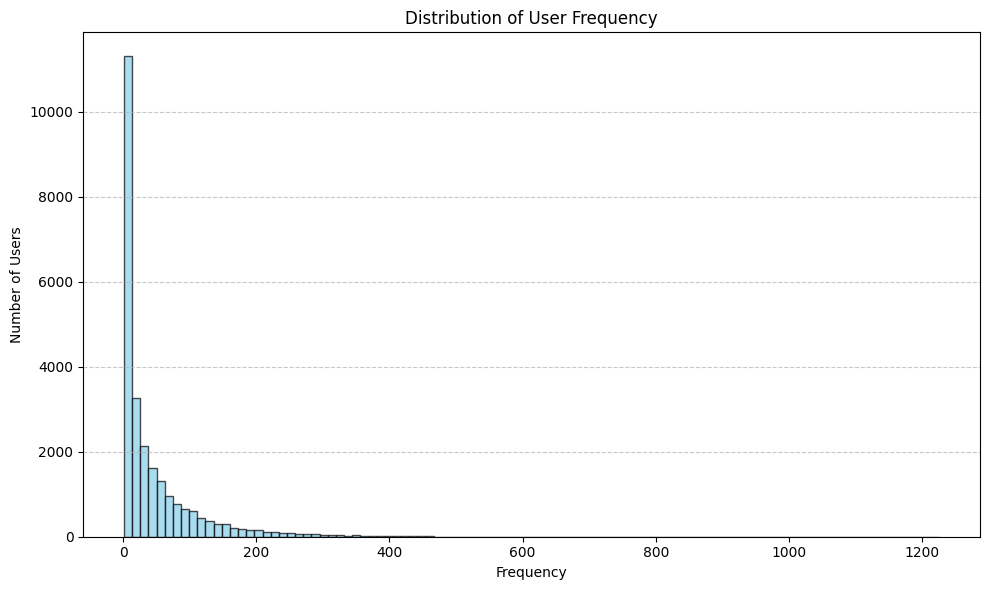

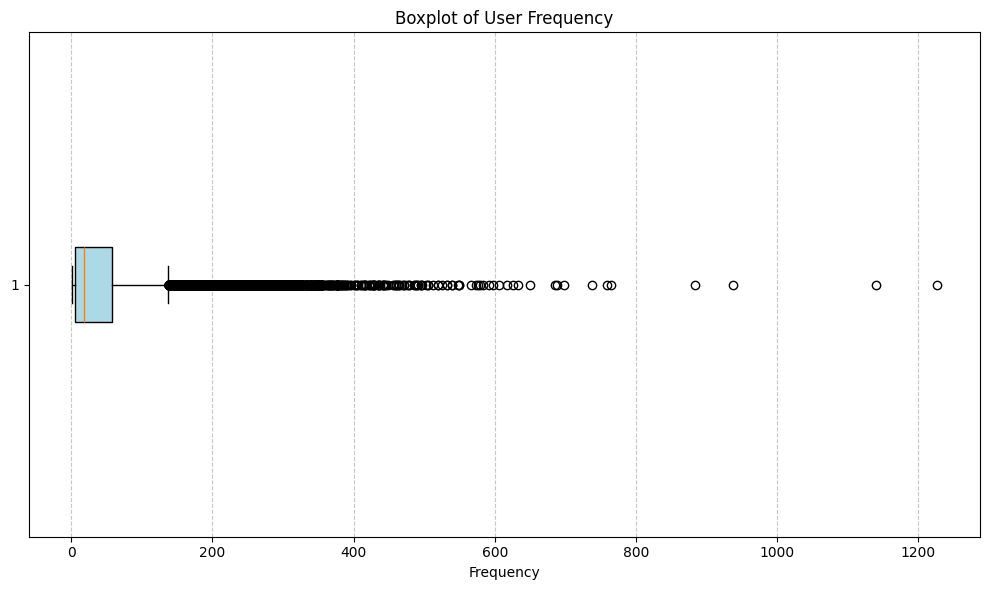

пользователей в словаре: 27769
итого пользователей в history: 25536
Доля пользователей которых мы хотим выбросить: 6%


In [14]:
# Построим распределение частоты встречаемости пользователей и ящик с усами

# Расчет частоты встречаемости каждого user_id
user_id_counts = history['user_id'].value_counts()

# Построим гистограмму распределения частоты встречаемости пользователей
plt.figure(figsize=(10, 6))
plt.hist(user_id_counts, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of User Frequency")
plt.xlabel("Frequency")
plt.ylabel("Number of Users")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Построим ящик с усами для распределения частоты
plt.figure(figsize=(10, 6))
plt.boxplot(user_id_counts, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Boxplot of User Frequency")
plt.xlabel("Frequency")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Выводим выбросы
q1 = user_id_counts.quantile(0.25)
q3 = user_id_counts.quantile(0.75)
iqr = q3 - q1

# Условия для выбросов
lower_bound = q1 - 2 * iqr
upper_bound = q3 + 2 * iqr
outliers = user_id_counts[(user_id_counts < lower_bound) | (user_id_counts > upper_bound)]

# Выводим количество и сами выбросы
print(f'пользователей в словаре: {users.shape[0]}')
print(f'итого пользователей в history: {len(user_id_counts)}')
print(f'Доля пользователей которых мы хотим выбросить: {round(len(outliers) / len(user_id_counts) * 100)}%')


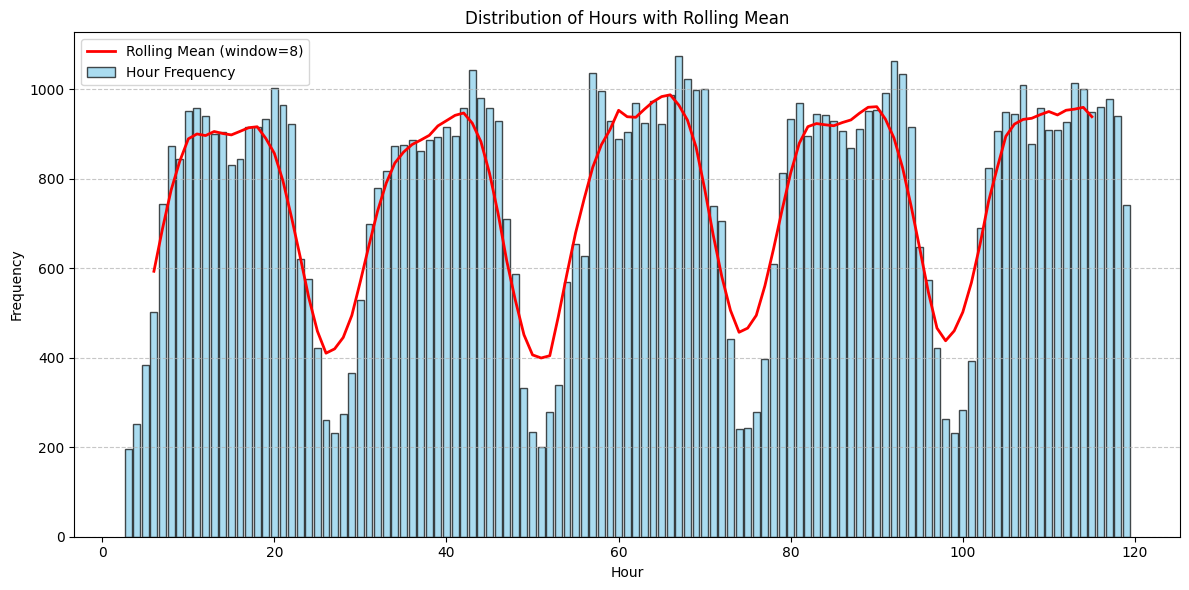

In [15]:
# пока оставим это, посмотрим на разные фичи

# Построим гистограмму распределения часов просмотра
hour_counts = history[history['hour'] < 120 ]['hour'].value_counts().sort_index()  # Считаем частоту каждого часа
hours = hour_counts.index
frequencies = hour_counts.values

# Рассчитаем скользящее среднее с окном 8
rolling_mean = np.convolve(frequencies, np.ones(8) / 8, mode='valid')

# Построим график с гистограммой и кривой скользящего среднего
plt.figure(figsize=(12, 6))

# Гистограмма
plt.bar(hours, frequencies, color='skyblue', edgecolor='black', alpha=0.7, label='Hour Frequency')

# Кривая скользящего среднего
plt.plot(hours[3:len(hours)-4], rolling_mean, color='red', linewidth=2, label='Rolling Mean (window=8)')

plt.title("Distribution of Hours with Rolling Mean")
plt.xlabel("Hour")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:
# Найдем длину цикла по данным
# Вычислим частоту основных пиков с помощью Fast Fourier Transform (FFT)
fft_result = np.fft.fft(frequencies)
frequencies_spectrum = np.fft.fftfreq(len(frequencies), d=1)  # Частоты FFT

# Определим основной цикл как обратную величину частоты с максимальной амплитудой (кроме нулевой частоты)
amplitudes = np.abs(fft_result)
dominant_frequency_index = np.argmax(amplitudes[1:]) + 1  # Игнорируем нулевую частоту
dominant_cycle_length = 1 / frequencies_spectrum[dominant_frequency_index]

# Определим фазы цикла (начало, середина, конец)
cycle_length = int(dominant_cycle_length)
phases = {
    "start": range(0, cycle_length // 3),
    "middle": range(cycle_length // 3, 2 * cycle_length // 3),
    "end": range(2 * cycle_length // 3, cycle_length)
}

dominant_cycle_length, phases

(23.4, {'start': range(0, 7), 'middle': range(7, 15), 'end': range(15, 23)})

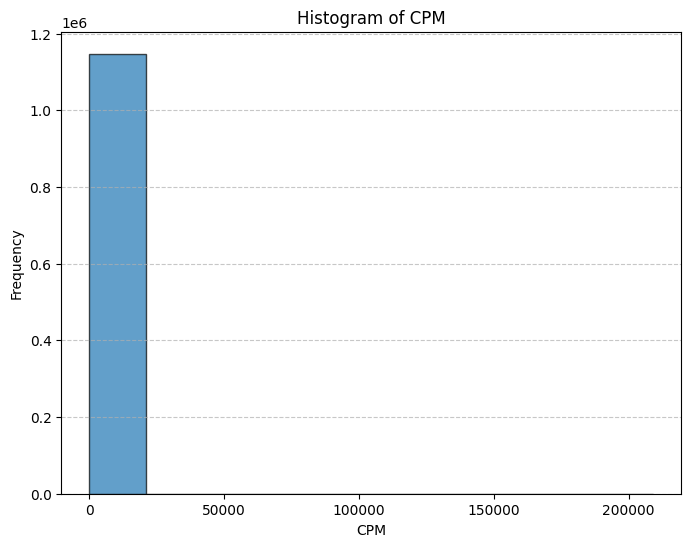

In [21]:
# посмотрим на распределение CPM

plt.figure(figsize=(8, 6))
plt.hist(history['cpm'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of CPM')
plt.xlabel('CPM')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

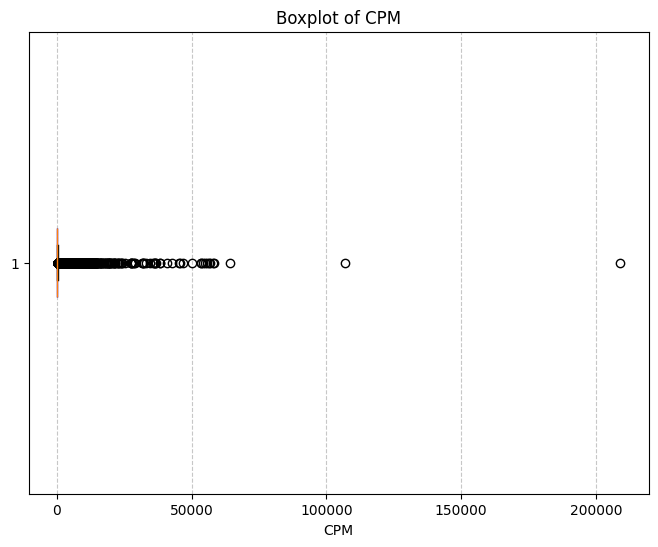

In [22]:
# построим ящик с усами

plt.figure(figsize=(8, 6))
plt.boxplot(history['cpm'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue", color="blue"))
plt.title('Boxplot of CPM')
plt.xlabel('CPM')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [32]:
# явно видны выбросы, надо удалить их

#эмпирически подберем порог, который оставит только те случаи когда CPM меньше 1000, расстаемся с 1.4% данных
history[history['cpm'] < 1000].shape[0] / history.shape[0]
filtered_history = history[history['cpm'] < 1000]


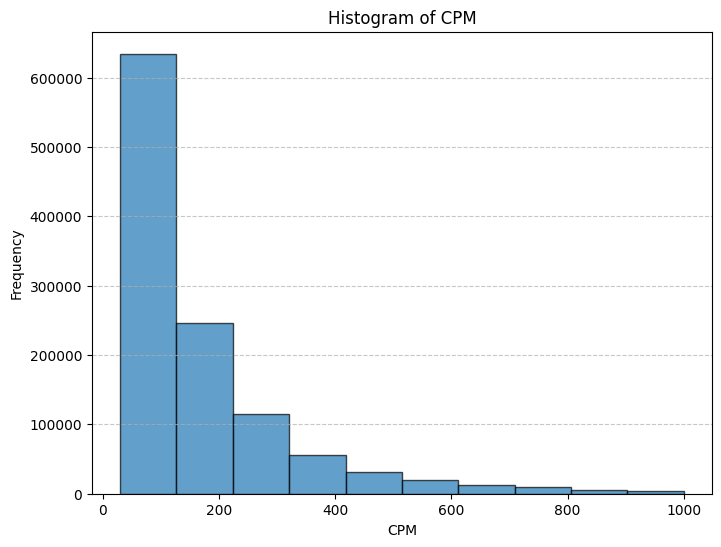

In [34]:
#посмотрим на распределение еще раз

plt.figure(figsize=(8, 6))
plt.hist(filtered_history['cpm'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of CPM')
plt.xlabel('CPM')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


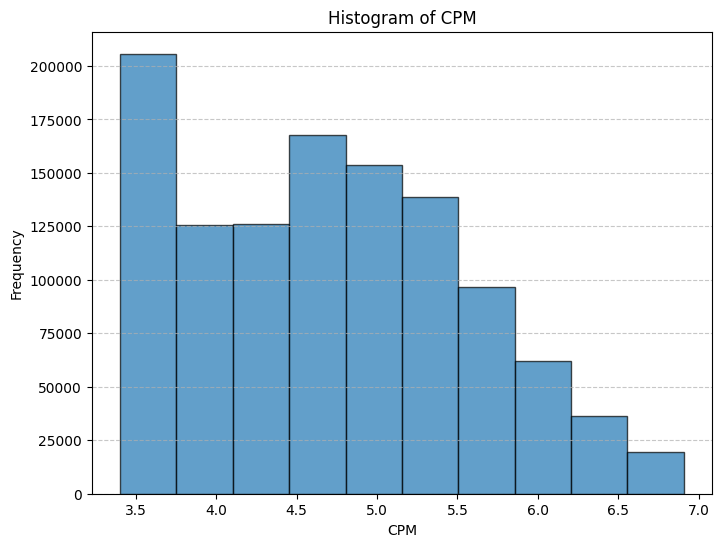

In [35]:
# прологарифмируем для наглядности

plt.figure(figsize=(8, 6))
plt.hist(np.log(filtered_history['cpm']), bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of CPM')
plt.xlabel('CPM')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [39]:
# теперь, так как мы знаем что у нас часы начинаются с некоторого дня с 00:00, заменим абсолютное значение часов на номер часа в сутках

filtered_history['hour_rel'] = filtered_history['hour'] % 24

/var/folders/rd/k4w0k0_51ms9k7065r_6h99r0000gn/T/ipykernel_95096/887601143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_history['hour_rel'] = filtered_history['hour'] % 24


In [41]:
filtered_history['hour_rel'].isna().sum()

0

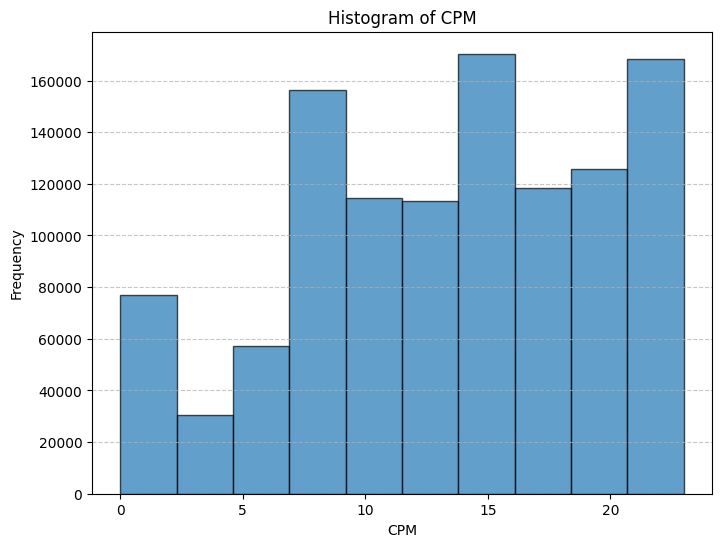

In [44]:
# отлично, теперь посмотрим на распределение часов


plt.figure(figsize=(8, 6))
plt.hist(filtered_history['hour_rel'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of CPM')
plt.xlabel('CPM')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [45]:
# теперь посмотрим распределение по регионам, для этого нам надо добавить по ID пользователей

filtered_history_users = pd.merge(filtered_history, users, on='user_id', how='left')



In [46]:
filtered_history_users

,hour,cpm,publisher,user_id,hour_rel,sex,age,city_id
0,10,30.00,1,15661,10,2,28,68
1,8,41.26,1,8444,8,1,41,0
2,7,360.00,1,15821,7,1,24,0
3,18,370.00,1,21530,18,2,17,13
4,8,195.00,2,22148,8,1,23,7
...,...,...,...,...,...,...,...,...
1131898,382,45.00,1,7871,22,1,19,0
1131899,360,33.35,1,7992,0,1,35,7
1131900,381,205.00,1,21516,21,1,27,13
1131901,383,37.50,1,8224,23,1,33,122


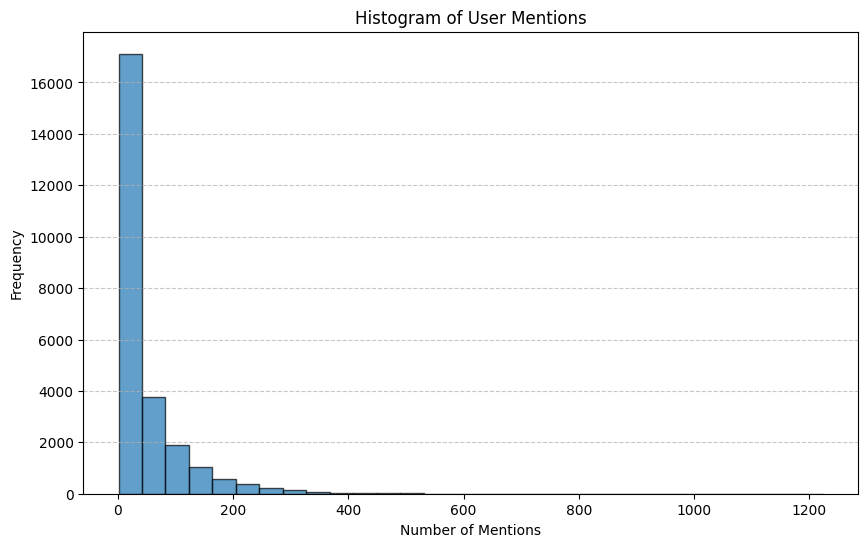

In [47]:
# теперь посмострим количество упоминаний каждого пользователя

# считаем упоминание каждого пользователя по ID
user_mentions = filtered_history_users['user_id'].value_counts()

# строим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(user_mentions, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of User Mentions')
plt.xlabel('Number of Mentions')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [53]:
filtered_users = user_mentions[(user_mentions > 30) & (user_mentions <= 500)]

np.sum(filtered_users)

967658

In [58]:
#нас интересуют только те пользователи у которых количество упоминаний более 30, так как это потребуется нам в дальнейшем, остальных надо убрать, 
# кроме того надо убрать пользователей количество упоминаний которых боллее 500

filtered_users = user_mentions[(user_mentions > 30) & (user_mentions <= 500)]

print(f'Сколько процентов датасета оставляем при фильтрации пользователей: {round(np.sum(filtered_users) / filtered_history_users.shape[0], 2) * 100} %')

filtered_history_users = filtered_history_users[filtered_history_users['user_id'].isin(filtered_users.index)]


Сколько процентов датасета оставляем при фильтрации пользователей: 85.0 %


In [59]:
filtered_history_users.shape

(967658, 8)

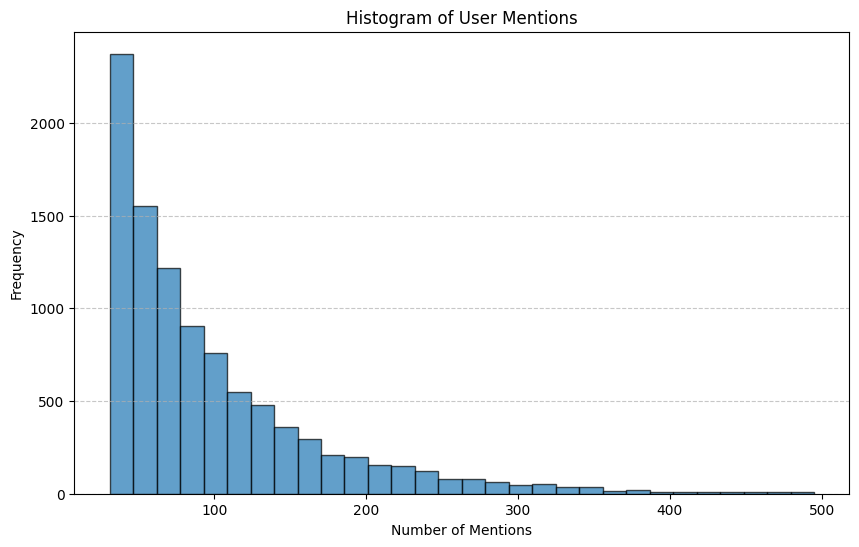

In [60]:
# смотрим распределение еще раз

# считаем упоминание каждого пользователя по ID
user_mentions = filtered_history_users['user_id'].value_counts()

# строим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(user_mentions, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histogram of User Mentions')
plt.xlabel('Number of Mentions')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Наша задача вычислить вероятность того что событие состоится исходя из комбинации вероятностей событий при условии определенных объектов, пользователей. Задача сводится к тому чтобы трансформировать данные history таким образом чтобы можно было вычислить вероятность состоявшегося события, то есть history это список положительных исходов, нам надо вычислить вероятность каждого исхода, то есть уже состоявшего события. При этом мы не располагаем датасетом ненаступивших событий, то есть нам надо как-то восставносить пространство всех исходов. Будем использовать метод PU-классификации.
4) Агментация датасета: у нас есть метрики час показа, площадка показа, пол, возраст, CPM, регион. Мы можем брать объект и генерировать новый объект с измененными признаками при этом присваивать ему метку U - unlabeled, но изменения признаков объекта должны приходить из того же распределения что и сам объект. Что тут можно сделать: итеративно апроксимируем распределение признака объекта по id пользователя (колонку ID все же сохраняем), как апроксимировать распределения вопрос?? как? аппроксимируем распределение каждого признака объекта (пользователя) по фичам: CPM, Hour, далее генерируем случайные числа которые придут из этого аппроксимированного распределения и ставим метку unlabeled, делаем так 10 раз для каждого объекта, тем самым расширяем датасет в 10 раз, остальные признаки остаются неизменными. Так мы сохраним баланс классов, в том числе по publisher, потому что нам важно оставить распределение площадок как было.
После того как мы сделали датасет, обучим PU-классификатор и определим вероятности P-классов, после этого применим Catboost только на P классах с целевой фичой - вероятность и обучим его

### Аугментация датасета

У нас есть только положительные исходы, то есть пользователь посмотрел рекламу, но для того чтобы перейти к вероятности того что пользователь посмотрел рекламу нам нужно все множество исходов, которого у нас нет.

Делать будем следующее:
- Определим фичи которые будут изменяться, их всего 2 - CPM и hour_rel, так как все остальные фичи отностяся к пользователю или региону
- регион трогать не будем, так как это категориальный признак и мы хотим сохранить баланс этих категорий "регион" и в аугментированном датасете тоже
- нам надо апроксимировать многомерное распределение (двумерное) по двум фичам и потом генерировать случайную величину из этого распределения, будем делать так 10 раз для каждого объекта, новым объектам будем присваивать метку 0 (что в данном случае означает unlabeled), для исходного объета будем присваивать метку 1 (positive)
- распределение мы апроксимируем по всей выборке, так как если будем это делать по USER-id то просто получим идентичное положительным исходам распределение, а нам это не нужно
- далее итеративно проводим кластеризацию по каждому пользователю и смотрим есть ли кластер только с U-классами, если есть то его можно определить как множество негативных примеров
- после определения негативных примеров, мы убираем все U данные которые не вошли в кластер и переходим к задаче бинарной классификации
- обучаем модель Catboost на аугментированном наборе данных
- переходим к вероятностям

In [67]:
# напишем функцию и попробуем сделать это на одном USER ID

def generate_unlabeled_data(df, n_samples_per_object=10, bandwidth=0.5):
    """
    Генерируем unlabeled данные на основе KDE по всей выборке.

    Параметры:
    - df: DataFrame, должен содержать колонки user_id, CPM, hour_rel, region и т.д.
    - n_samples_per_object: сколько новых объектов генерировать на каждый исходный объект
    - bandwidth: параметр сглаживания для KDE

    Возврат:
    Объединённый DataFrame с новыми (unlabeled) и старыми (labeled=1) данными.
    """
    # Извлекаем фичи для KDE
    X = df[['cpm', 'hour_rel']].values

    # Строим KDE-модель
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)

    # Будем генерировать unlabeled для каждого объекта
    synthetic_rows = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating synthetic data"):
        # Генерируем новые точки из KDE
        new_points = kde.sample(n_samples_per_object)

        for p in new_points:
            # Создаём новую строку, копируя категориальные признаки
            new_row = row.copy()
            new_row['cpm'] = p[0]
            new_row['hour_rel'] = int(round(p[1]))  # hour_rel округляем до целого числа

            # Проверяем диапазон для hour_rel (0-23)
            if new_row['hour_rel'] < 0:
                new_row['hour_rel'] = 0
            elif new_row['hour_rel'] > 23:
                new_row['hour_rel'] = 23

            new_row['label'] = 0  # unlabeled
            synthetic_rows.append(new_row)

    # Создаём DataFrame из сгенерированных данных
    synthetic_df = pd.DataFrame(synthetic_rows, columns=df.columns.tolist() + ['label'])

    # Исходные данные с label=1
    original_df = df.copy()
    original_df['label'] = 1

    # Объединяем
    combined_df = pd.concat([original_df, synthetic_df], ignore_index=True)

    return combined_df

In [89]:
def find_negative_clusters_for_user(df, user_id, eps=0.1, min_samples=5):
    """
    Для заданного user_id проводим кластеризацию и ищем кластеры, состоящие только из unlabeled (label=0).
    
    Параметры:
    - df: DataFrame, результат объединения original + synthetic
    - user_id: интересующий нас пользователь
    - eps, min_samples: параметры DBSCAN
    
    Возврат:
    Словарь с информацией о найденных негативных кластерах.
    """
    user_df = df[df['user_id'] == user_id]
    
    if user_df.shape[0] == 0:
        return {"status": "no_data_for_user"}

    # Берём фичи для кластеризации, напр. CPM и hour_rel
    X_user = user_df[['cpm', 'hour_rel', 'sex', 'age', 'city_id']].values
    
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X_user)
    cluster_labels = clustering.labels_
    
    user_df = user_df.copy()
    user_df['cluster'] = cluster_labels
    
    # Анализируем кластеры
    negative_clusters = []
    for c in np.unique(cluster_labels):
        cluster_data = user_df[user_df['cluster'] == c]
        
        # Если в кластере нет исходных данных (label=1), значит это полностью U-кластер
        if (cluster_data['label'] == 1).sum() == 0:
            negative_clusters.append(c)
    
    return {
        "status": "done",
        "negative_clusters": negative_clusters,
        "clustered_data": user_df
    }

In [68]:
# Генерируем unlabeled данные
augmented_df = generate_unlabeled_data(filtered_history_users, n_samples_per_object=10, bandwidth=0.5)

Generating synthetic data: 100%|██████████| 967658/967658 [34:30<00:00, 467.35it/s]  


In [69]:
# сохраним полученный расширенный датасет

augmented_df.to_csv('augmented_history.csv')

In [70]:
augmented_df.shape

(10644238, 9)

In [71]:
augmented_df.head()

,hour,cpm,publisher,user_id,hour_rel,sex,age,city_id,label
0,10.0,30.00,1.0,15661.0,10.0,2.0,28.0,68.0,1.0
1,8.0,41.26,1.0,8444.0,8.0,1.0,41.0,0.0,1.0
2,7.0,360.00,1.0,15821.0,7.0,1.0,24.0,0.0,1.0
3,18.0,370.00,1.0,21530.0,18.0,2.0,17.0,13.0,1.0
4,8.0,195.00,2.0,22148.0,8.0,1.0,23.0,7.0,1.0


In [83]:
def convert_columns_to_int(df, columns):
    """
    Преобразует указанные столбцы DataFrame в тип int.

    Параметры:
    - df: DataFrame, в котором нужно преобразовать столбцы.
    - columns: список имён столбцов для преобразования.

    Возврат:
    DataFrame с преобразованными столбцами.
    """
    for column in columns:
        df[column] = df[column].astype(int)
    return df

In [84]:
columns_to_convert = ['hour', 'publisher', 'user_id', 'hour_rel', 'sex', 'age', 'city_id', 'label']
augmented_df = convert_columns_to_int(augmented_df, columns_to_convert)

In [86]:
augmented_df.head()

,hour,cpm,publisher,user_id,hour_rel,sex,age,city_id,label
0,10,30.00,1,15661,10,2,28,68,1
1,8,41.26,1,8444,8,1,41,0,1
2,7,360.00,1,15821,7,1,24,0,1
3,18,370.00,1,21530,18,2,17,13,1
4,8,195.00,2,22148,8,1,23,7,1


In [96]:
# выберем пользователя 

test_user = augmented_df[augmented_df['user_id'] == 8444]

In [97]:
test_user.head()

,hour,cpm,publisher,user_id,hour_rel,sex,age,city_id,label
1,8,41.26,1,8444,8,1,41,0,1
1315,11,49.14,1,8444,11,1,41,0,1
2549,14,30.00,1,8444,14,1,41,0,1
4223,8,119.70,1,8444,8,1,41,0,1
4264,14,45.00,1,8444,14,1,41,0,1


In [109]:
def visualize_user_data_with_clustering(augmented_df, user_id):
    """
    Визуализирует данные для указанного пользователя, раскрашивая точки в зависимости от кластеров.

    Параметры:
    - augmented_df: DataFrame, содержащий данные.
    - user_id: идентификатор пользователя для фильтрации данных.
    """
    test_user = augmented_df[augmented_df['user_id'] == user_id]
    X = test_user[['cpm', 'hour_rel']].values

    # Применяем HDBSCAN для кластеризации
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, allow_single_cluster=False).fit(X)
    test_user['cluster'] = clusterer.labels_

    plt.figure(figsize=(10, 6))
    for cluster in np.unique(test_user['cluster']):
        subset = test_user[test_user['cluster'] == cluster]
        color = 'red' if subset['label'].iloc[0] == 0 else 'blue'
        label = f"Cluster {cluster} ({'U' if color == 'red' else 'P'})"
        plt.scatter(subset['cpm'], subset['hour_rel'], label=label, alpha=0.7, color=color)

    plt.title(f'Clustering Results for User {user_id}')
    plt.xlabel('CPM')
    plt.ylabel('Hour')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Проверка кластеров, содержащих только U-примеры
    u_only_clusters = []
    for cluster in np.unique(test_user['cluster']):
        cluster_data = test_user[test_user['cluster'] == cluster]
        if all(cluster_data['label'] == 0):
            u_only_clusters.append(cluster)

    print(f"Clusters with only U examples: {u_only_clusters}")

    # Подсчёт P и U примеров в кластерах, содержащих только U-примеры
    u_only_data = test_user[test_user['cluster'].isin(u_only_clusters)]
    p_count = len(test_user[test_user['label'] == 1])
    u_count = len(u_only_data[u_only_data['label'] == 0])

    print(f"P examples in U-only clusters: {p_count}")
    print(f"U examples in U-only clusters: {u_count}")

/var/folders/rd/k4w0k0_51ms9k7065r_6h99r0000gn/T/ipykernel_95096/3942956495.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_user['cluster'] = clusterer.labels_


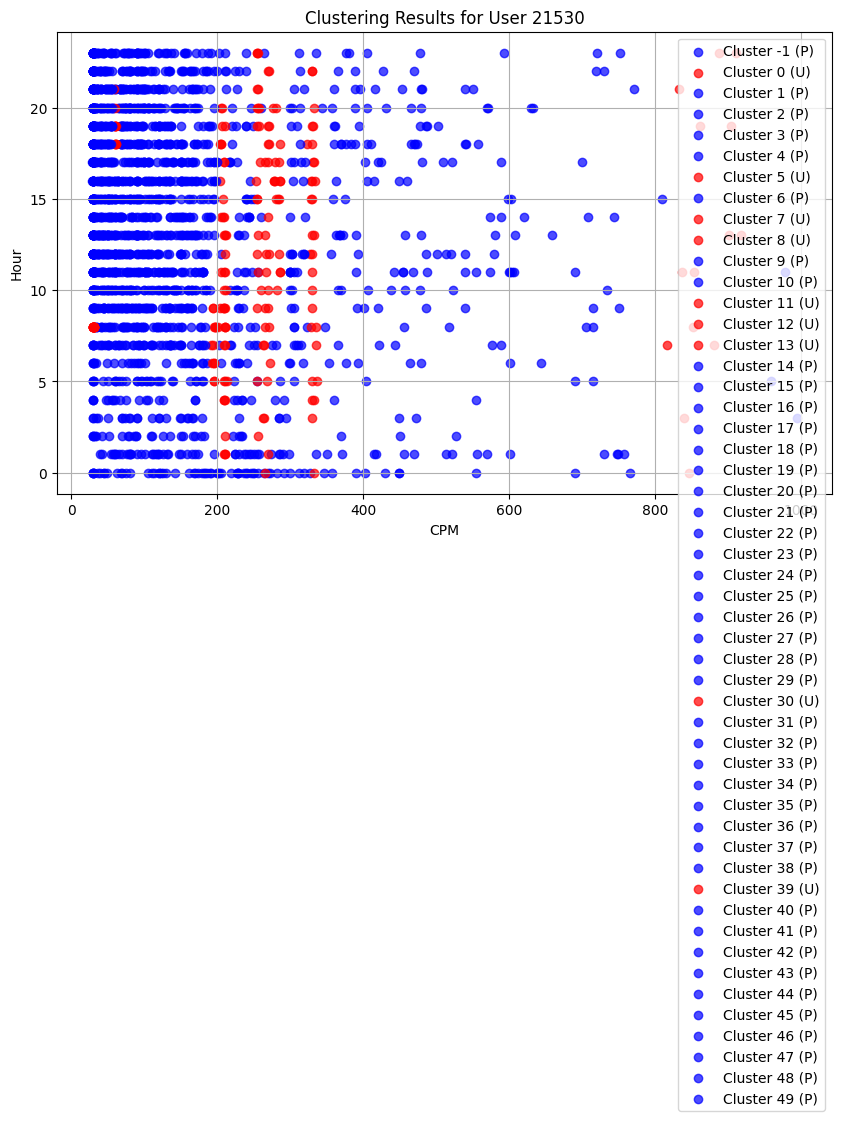

Clusters with only U examples: [0, 5, 7, 8, 11, 12, 13, 30, 39]
P examples in U-only clusters: 196
U examples in U-only clusters: 190


In [111]:
visualize_user_data_with_clustering(augmented_df, 21530)

In [114]:
# отлично теперьу нас есть алгоритм который ищет кластеры только с U-примерами, будем считать что это наши негативные примеры
# теперь наша задача сформировать PN-датасет
# итеративно проходим по всем ID пользователей в датасете
# определяем PN примеры
# убираем все остальные примеры

def create_pn_dataset(augmented_df):
    """
    Создаёт PN-датасет, проходя итеративно по всем user_id в выборке.

    Параметры:
    - augmented_df: DataFrame с примерами (P и U), сгенерированными для пользователей.

    Возврат:
    DataFrame, содержащий только P-примеры и негативные примеры, найденные в кластерах с только U-примерами.
    """
    pn_rows = []

    for user_id in tqdm(augmented_df['user_id'].unique(), desc="Processing users"):
        test_user = augmented_df[augmented_df['user_id'] == user_id].copy()
        X = test_user[['cpm', 'hour_rel']].values

        # Применяем HDBSCAN для кластеризации
        clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, allow_single_cluster=False).fit(X)
        test_user.loc[:, 'cluster'] = clusterer.labels_

        # Найдём кластеры с только U-примерами
        u_only_clusters = []
        for cluster in np.unique(test_user['cluster']):
            cluster_data = test_user[test_user['cluster'] == cluster]
            if all(cluster_data['label'] == 0):
                u_only_clusters.append(cluster)

        # Добавляем P-примеры и негативные примеры из U-кластеров
        pn_data = test_user[(test_user['label'] == 1) | (test_user['cluster'].isin(u_only_clusters))]
        pn_rows.append(pn_data)

    # Объединяем все PN данные
    pn_dataset = pd.concat(pn_rows, ignore_index=True)
    return pn_dataset

In [115]:
pn_dataset = create_pn_dataset(augmented_df)

Processing users: 100%|██████████| 9828/9828 [02:30<00:00, 65.43it/s] 


In [116]:
pn_dataset.shape

(2299853, 10)

In [117]:
pn_dataset.to_csv('pn_dataset.csv')

In [22]:
pn_dataset = pd.read_csv('pn_dataset.csv')

In [25]:
#ура у нас есть датасет, теперь обучим классификатор
def prepare_data(pn_dataset):
    """
    Подготовка данных для обучения.
    - Убираем колонку `hour`, так как уже есть `hour_rel`.
    - Определяем категориальные фичи.

    Возврат:
    X (фичи), y (целевая переменная), категориальные индексы.
    """
    print("[INFO] Starting data preparation...")
    # Убираем ненужные колонки
    pn_dataset = pn_dataset.drop(columns=['hour'], errors='ignore')

    # Определяем целевую переменную и фичи
    y = pn_dataset['label']
    X = pn_dataset.drop(columns=['label', 'user_id', 'Unnamed: 0'])  # Убираем метку и идентификатор пользователя

    # Категориальные фичи
    categorical_features = ['hour_rel', 'sex', 'city_id', 'publisher']
    cat_feature_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]

    print(f"[INFO] Features shape: {X.shape}, Target shape: {y.shape}")
    print(f"[INFO] Categorical feature indices: {cat_feature_indices}")

    return X, y, cat_feature_indices

In [26]:
X, y, cat_feature_indices = prepare_data(pn_dataset)

[INFO] Starting data preparation...
[INFO] Features shape: (2299853, 7), Target shape: (2299853,)
[INFO] Categorical feature indices: [2, 3, 5, 1]


In [27]:
X

,cpm,publisher,hour_rel,sex,age,city_id,cluster
0,30.00,1,10,2,28,68,8
1,42.50,1,10,2,28,68,8
2,40.75,1,2,2,28,68,-1
3,30.00,1,9,2,28,68,8
4,30.00,1,14,2,28,68,8
...,...,...,...,...,...,...,...
2299848,225.45,1,13,2,27,21,1
2299849,71.00,1,21,2,27,21,1
2299850,130.00,1,21,2,27,21,1
2299851,45.00,1,22,2,27,21,1


In [63]:
# Подготовка данных

def prepare_data(pn_dataset):
    """
    Подготовка данных для обучения.
    - Убираем колонку `hour`, так как уже есть `hour_rel`.
    - Определяем категориальные фичи.

    Возврат:
    X (фичи), y (целевая переменная), категориальные индексы.
    """
    print("[INFO] Starting data preparation...")

    # Перемешиваем данные
    pn_dataset = pn_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    print("[INFO] Data shuffled.")
    # Убираем ненужные колонки
    pn_dataset = pn_dataset.drop(columns=['hour'], errors='ignore')

    # Определяем целевую переменную и фичи
    y = pn_dataset['label']
    X = pn_dataset.drop(columns=['label', 'user_id', 'Unnamed: 0'])  # Убираем метку и идентификатор пользователя

    # Категориальные фичи
    categorical_features = ['hour_rel', 'sex', 'city_id', 'publisher']
    cat_feature_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]

    print(f"[INFO] Features shape: {X.shape}, Target shape: {y.shape}")
    print(f"[INFO] Categorical feature indices: {cat_feature_indices}")

    return X, y, cat_feature_indices

# Разделение на обучающую и тестовую выборки
def split_data(X, y):
    print("[INFO] Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"[INFO] Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
    return X_train, X_test, y_train, y_test

# Обучение CatBoost в батчах
def train_in_batches_manual(X_train, y_train, cat_features, batch_size=100000, iterations=500):
    """
    Обучение CatBoostClassifier на батчах данных вручную.

    Параметры:
    - X_train: фичи для обучения.
    - y_train: метки для обучения.
    - cat_features: индексы категориальных фичей.
    - batch_size: размер батча.
    - iterations: количество итераций на каждый батч.

    Возврат:
    Обученная модель.
    """
    print("[INFO] Starting manual batch training...")
    model = None

    for i in tqdm(range(0, len(X_train), batch_size), desc="Training batches"):
        end = i + batch_size
        batch_X = X_train.iloc[i:end]
        batch_y = y_train.iloc[i:end]
        pool = Pool(batch_X, batch_y, cat_features=cat_features)

        if model is None:
            model = CatBoostClassifier(
                iterations=iterations,
                learning_rate=0.05,
                depth=12,
                cat_features=cat_features,
                verbose=10,
                task_type="GPU",
                random_seed=42
            )
            model.fit(pool, verbose=10)
        else:
            model.fit(pool, verbose=10, use_best_model=False)

    return model

# Оценка модели и визуализация метрик
def evaluate_model(model, X_test, y_test):
    """
    Оценка модели и вывод метрик.
    """
    print("[INFO] Evaluating the model...")
    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Метрики
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"[INFO] F1-Score: {f1}")
    print(f"[INFO] ROC-AUC: {roc_auc}")

    # ROC-кривая
    print("[INFO] Plotting ROC Curve...")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC-AUC: {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()


In [65]:
# Подготовка данных
print("[INFO] Preparing the dataset...")
X, y, cat_features = prepare_data(pn_dataset)
X_train, X_test, y_train, y_test = split_data(X, y)

[INFO] Preparing the dataset...
[INFO] Starting data preparation...
[INFO] Data shuffled.
[INFO] Features shape: (2299853, 7), Target shape: (2299853,)
[INFO] Categorical feature indices: [2, 3, 5, 1]
[INFO] Splitting data into train and test sets...
[INFO] Training set size: 1839882, Test set size: 459971


In [81]:
X_train
# вот такая модель данных 

,cpm,publisher,hour_rel,sex,age,city_id,cluster
483842,30.000000,1,22,2,18,958,9
248112,103.145360,2,21,2,29,0,14
20980,202.000000,7,13,1,26,43,5
1569642,240.314953,1,13,2,35,0,1
1862180,205.380000,1,8,2,32,19,11
...,...,...,...,...,...,...,...
708767,30.183875,3,18,1,40,270,38
2185682,29.843967,1,11,1,43,0,41
163013,29.289360,3,9,1,33,0,25
1077591,174.000000,2,7,2,23,295,21


In [64]:
#модель обучалась в другом ноутбуке

### Резульаты обучения моделей

- Catboost показал ROC-AUC 0.9
- Нейросеть не справилась с заданием
- Будем использовать Catboost
- Реализация обучения, архитектура и гиперпараметры лежат в файле VK_hackathon_training_model.ipynb

### Теперь займемся рассчетом предстказаний 

#### Идея задачи:
Имея обученную модель (например, CatBoost), мы хотим по валидационному набору оценить вероятность того, что произойдут определенные количества просмотров (хотя бы один просмотр, хотя бы два и т.д.) при условии, что показы будут осуществляться на наборе площадок (publishers) по определенным пользователям (user_ids) в заданный часовом диапазоне. Мы предполагаем, что каждое событие просмотра независимо и подчиняется биномиальному распределению.

Формула биномиального распределения для вероятности ровно k успехов из n экспериментов, при вероятности успеха p:

P(X=k)=C(n,k)⋅p 
k
 ⋅(1−p) 
(n−k)

$$
P(X=k) = C_n^k \times p^k \times (1-p)^{n-k}
$$

Нам же нужны вероятности "хотя бы k", то есть:

$$
P(X≥k)=1−\sum_{i=0}^{k−1}P(X=i)
$$

Алгоритм:
0) Загружаем модель из PKL (обучали на collab A100)
1) Берем строку из Validate
2) Разворачиваем множество пользователей по ID
3) Разворачиваем площадки показа (будем взвешивать вероятности от того на какой площадке планируется показ)
4) часовой диапазон по номерам часов, вычисляем номер часа в сутках
5) Подаем в модель подготовленный объект (идентичный тому какой был на обучении)
6) Получаем предсказание вероятности для объекта
7) Итеративно проходим по всем объектам, взвешиваем каждое предсказание в зависимости от того на какой площадке планируется показ (простая доля просмотров на площадке от всех просмотров из исходного датасета history)
8) По формуле биномиального распределения считаем вероятность показа хотя бы 1, хотя бы 2, хотя бы 3, округляем до 4 знака
9) Рассчитываем целевую метрику

In [67]:
# теперь займемся инференсом

model_path = '/Users/andreykhalov/HULK/PHD/MFTI/3_hackathon/catboost_model_3.pkl'

In [68]:
with open(model_path, 'rb') as f:
    model_catboost = pickle.load(f)

In [69]:
# рассчитаем долю каждой площадки в общем количестве показов

publisher_counts = history['publisher'].value_counts()
total_views = publisher_counts.sum()
publisher_weights = (publisher_counts / total_views).to_dict()

print("[INFO] Publisher weights:")
for p, w in publisher_weights.items():
    print(f"Publisher {p}: {w:.6f}")

[INFO] Publisher weights:
Publisher 1: 0.603329
Publisher 2: 0.237867
Publisher 3: 0.062834
Publisher 7: 0.057615
Publisher 9: 0.008856
Publisher 5: 0.006327
Publisher 6: 0.005171
Publisher 10: 0.003687
Publisher 11: 0.003509
Publisher 8: 0.003158
Publisher 4: 0.001992
Publisher 12: 0.001674
Publisher 16: 0.001160
Publisher 17: 0.000954
Publisher 14: 0.000919
Publisher 15: 0.000491
Publisher 18: 0.000171
Publisher 13: 0.000151
Publisher 20: 0.000082
Publisher 19: 0.000047
Publisher 21: 0.000008


In [70]:
# ставим дефолтные значения параметров

mean_sex = 1
mean_city_id = 0
mean_age = users['age'].mean()

In [71]:
def poisson_binomial_p_at_least(k, probabilities):
    """
    Расчёт P(X≥k) для пуассоново-биномиального распределения.
    """
    n = len(probabilities)
    pb_dist = [1.0] + [0.0]*n
    for p in probabilities:
        for i in range(n, 0, -1):
            pb_dist[i] = pb_dist[i]*(1-p) + pb_dist[i-1]*p
        pb_dist[0] = pb_dist[0]*(1-p)
    return 1 - sum(pb_dist[:k])

In [72]:
def get_smoothed_log_mape_column_value(responses_column, answers_column, epsilon):
    return np.abs(np.log((responses_column + epsilon) / (answers_column + epsilon))).mean()

def get_smoothed_mean_log_accuracy_ratio(answers, responses, epsilon=0.005):
    """
    Рассчёт итоговой метрики.
    """
    log_accuracy_ratio_mean = np.array([
        get_smoothed_log_mape_column_value(responses.at_least_one, answers.at_least_one, epsilon),
        get_smoothed_log_mape_column_value(responses.at_least_two, answers.at_least_two, epsilon),
        get_smoothed_log_mape_column_value(responses.at_least_three, answers.at_least_three, epsilon),
    ]).mean()

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)
    return percentage_error.round(2)

In [73]:
def get_user_info(u_id):
    """
    Получить информацию о пользователе: sex, city_id, age.
    В случае отсутствия информации берем среднее по выборке.
    """
    row = users[users['user_id'] == u_id]
    if len(row) == 0:
        # Пользователь не найден, подставляем средние
        return mean_sex, mean_city_id, mean_age
    sex_val = row['sex'].values[0]
    city_val = row['city_id'].values[0]
    age_val = row['age'].values[0]

    # Проверяем пропуски и подставляем среднее, если нужно
    sex_val = sex_val if not pd.isna(sex_val) else mean_sex
    city_val = city_val if not pd.isna(city_val) else mean_city_id
    age_val = age_val if not pd.isna(age_val) else mean_age

    return sex_val, city_val, age_val

In [ ]:
def predict_task(row):
    """
    Рассчитать at_least_one, at_least_two, at_least_three для одной строки из validate.
    """
    # Разворачиваем пользователей
    user_ids = [int(u) for u in row['user_ids'].split(',')]
    # Разворачиваем площадки
    publishers = [int(p) for p in row['publishers'].split(',')]
    # Часовой диапазон
    hour_range = list(range(row['hour_start'], row['hour_end'] + 1))
    hours_of_day = [h % 24 for h in hour_range]
    print(f'количество часов: {len(hours_of_day)}')
    cluster = -1

    # Формируем данные для предсказаний
    data_for_prediction = []
    combos = []

    for u in user_ids:
        sex, city_id, age = get_user_info(u)
        sex = int(sex)
        city_id = int(city_id)
        age = int(age)

        for h in hours_of_day:
            for p in publishers:
                data_for_prediction.append([
                    row['cpm'],  # cpm
                    p,            # publisher
                    h,           # hour_rel
                    sex,         # sex
                    age,         # age
                    city_id,     # city_id
                    cluster
                ])
                combos.append((u, h, p))

    # Если нет данных для предсказания, возвращаем нули
    if len(data_for_prediction) == 0:
        return 0.0, 0.0, 0.0

    # Создаём DataFrame с фиксированным порядком колонок
    pred_df = pd.DataFrame(data_for_prediction, columns=['cpm', 'publisher', 'hour_rel', 'sex', 'age', 'city_id', 'cluster'])

    # Отображаем первые строки для проверки
    print(f'Размер подвыборки для оценки: {pred_df.shape[0]}')

    # Предсказание вероятностей
    y_pred_proba = model_catboost.predict_proba(pred_df)[:, 1]

    # Расчёт через пуассоново-биномиальное распределение
    p_at_least_one = poisson_binomial_p_at_least(1, y_pred_proba)
    p_at_least_two = poisson_binomial_p_at_least(2, y_pred_proba)
    p_at_least_three = poisson_binomial_p_at_least(3, y_pred_proba)

    # Округляем до 4 знаков
    p_at_least_one = round(p_at_least_one, 4)
    p_at_least_two = round(p_at_least_two, 4)
    p_at_least_three = round(p_at_least_three, 4)

    return p_at_least_one, p_at_least_two, p_at_least_three

In [107]:
predictions = []
for i, task_row in validate.iterrows():
    p1, p2, p3 = predict_task(task_row)
    predictions.append((p1, p2, p3))

predictions_df = pd.DataFrame(predictions, columns=['at_least_one', 'at_least_two', 'at_least_three'])

количество часов: 96
Размер подвыборки для оценки: 365952


KeyboardInterrupt: 

In [62]:
metric_value = get_smoothed_mean_log_accuracy_ratio(validate_answers, predictions_df)
print("Metric Value:", metric_value, "%")

NameError: name 'predictions_df' is not defined

In [9]:
# например возьмем первую строку

row = validate.iloc[0]

In [14]:
#разворачиваем часы, площадки показов, пользователей
user_ids = row['user_ids'].split(',')
user_ids = [int(u) for u in user_ids]
publishers = row['publishers'].split(',')
publishers = [int(p) for p in publishers]
hour_range = list(range(row['hour_start'], row['hour_end']+1))
# hour_rel – это час в сутках
hours_of_day = [h % 24 for h in hour_range]